In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

pd.options.display.float_format = "{:.2f}".format

In [386]:
#Leitura, limpeza e análise exploratória
places = pd.read_csv('/code/src/airbnb.csv')

#Após a leitura dos dados, o primeiro passo é remover colunas que não serão relevantes para nossa análise
places = places.drop(columns=[
    'host_is_superhost', 
    'instant_bookable', 
    'cancellation_policy'
])

#Para visualizarmos os primeiros registros e termos uma noção dos dados
places.head().T

,0,1,2,3,4
host_total_listings_count,1.00,2.00,10.00,10.00,2.00
neighbourhood_cleansed,Western Addition,Bernal Heights,Haight Ashbury,Haight Ashbury,Western Addition
latitude,37.77,37.75,37.77,37.76,37.78
longitude,-122.43,-122.42,-122.45,-122.45,-122.44
property_type,Apartment,Apartment,Apartment,Apartment,House
room_type,Entire home/apt,Entire home/apt,Private room,Private room,Entire home/apt
accommodates,3.00,5.00,2.00,2.00,5.00
bathrooms,1.00,1.00,4.00,4.00,1.50
bedrooms,1.00,2.00,1.00,1.00,2.00
beds,2.00,3.00,1.00,1.00,2.00


In [387]:
#para uma primeira análise quantitativa, agrupei os dados por vizinhança e tirei a média dos preços para ter
#uma projeção por região

pricesByRegion = places.groupby('neighbourhood_cleansed')['price'].mean()
pricesByRegion

neighbourhood_cleansed
Bayview                 121.61
Bernal Heights          183.47
Castro/Upper Market     235.95
Chinatown               179.90
Crocker Amazon          101.92
Diamond Heights         201.89
Downtown/Civic Center   174.68
Excelsior               123.57
Financial District      266.83
Glen Park               200.41
Golden Gate Park        315.00
Haight Ashbury          207.68
Inner Richmond          207.07
Inner Sunset            221.49
Lakeshore               116.43
Marina                  309.04
Mission                 225.46
Nob Hill                231.02
Noe Valley              236.21
North Beach             223.46
Ocean View              143.76
Outer Mission           142.96
Outer Richmond          174.73
Outer Sunset            142.17
Pacific Heights         345.45
Parkside                196.45
Potrero Hill            234.35
Presidio                105.00
Presidio Heights        347.07
Russian Hill            345.78
Seacliff                413.45
South of Market 

In [388]:
#Apesar de a média ser um dado interessante, é importante analisa-la em conjunto com o desvio padrão
#Logo, apesar das médias estarem bastante variadas, o desvio padrão de muitas regiões estão bastante altos
#Assim, pode não ser uma abordagem ideal olhar para as regiões

places.groupby('neighbourhood_cleansed')['price'].std()

neighbourhood_cleansed
Bayview                  83.00
Bernal Heights          126.34
Castro/Upper Market     174.60
Chinatown               122.98
Crocker Amazon          109.37
Diamond Heights         110.80
Downtown/Civic Center   164.92
Excelsior                95.81
Financial District      329.43
Glen Park               161.85
Golden Gate Park        322.04
Haight Ashbury          173.32
Inner Richmond          162.21
Inner Sunset            351.16
Lakeshore                67.97
Marina                  367.12
Mission                 440.27
Nob Hill                625.90
Noe Valley              194.57
North Beach             167.52
Ocean View              179.87
Outer Mission            99.07
Outer Richmond          132.70
Outer Sunset             94.28
Pacific Heights         669.47
Parkside                705.04
Potrero Hill            333.23
Presidio                   nan
Presidio Heights        402.27
Russian Hill            365.13
Seacliff                769.74
South of Market 

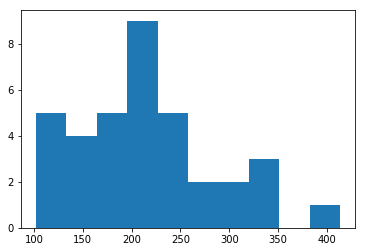

In [389]:
#Para termos uma visão gráfica da média, plotei um histograma para verificarmos como está a distribuição dos dados
#agrupados por região
count, bins, ignored = plt.hist(pricesByRegion)
plt.show()

In [390]:
#Após isso, coletei a média e o desvio padrão dos dados agrupados por região
mean = pricesByRegion.mean()
std = pricesByRegion.std()

#Dividi os dados em dois grupos de preços inicialmente. Acima e abaixo de dois desvios padrões da média.
higherPrices = places[places.price > (mean + (2*std))]
lowerPrices = places[places.price < (mean - (2*std))]

#Peguei então para complementar as informações a média de score dos preços mais altos
scoreHigher = higherPrices.groupby('neighbourhood_cleansed')['review_scores_rating'].mean()
print(scoreHigher.mean(), scoreHigher.std())

97.39116530477263 1.2733577096317639


In [391]:
#E também dos mais baixos
scoreLower = lowerPrices.groupby('neighbourhood_cleansed')['review_scores_rating'].mean()
print(scoreLower.mean(), scoreLower.std())

#Como podemos perceber, a média e o desvio padrão das avaliações dos imóveis mais caros são maiores e variam
#menos que dos imóveis mais baratos. Isso faz com que as avaliações dos imóveis mais caros sejam mais acertivas
#que dos imóveis mais baratos.

# Com isso, podemos observar que normalmente os estabelecimentos com maior valor são constantemente melhor avaliados
# pelos clientes, pois além de sua média ser mais alta, seu desvio padrão é menor, oscilando menos entre os imóveis.

92.61039946946109 4.870385027261021


In [392]:
def getCoordinates(dataframe):
    coordinates = []

    for latitude, longitude in zip(dataframe.latitude, dataframe.longitude):
        coordinates.append([latitude, longitude])
    
    return coordinates

In [393]:
def plotHeatMap(dataframe):
    mapa = folium.Map(location=[37.7693,-122.434],zoom_start=13)
    
    coordinates = getCoordinates(dataframe)
    
    HeatMap(coordinates).add_to(mapa)
    return mapa

In [394]:
#Com isso, plotei ainda um mapa mostrando um heatmap dos imóveis mais caros e mais baratos para extrairmos alguma
#informação relevante graficamente.
plotHeatMap(higherPrices)

In [395]:
plotHeatMap(lowerPrices)

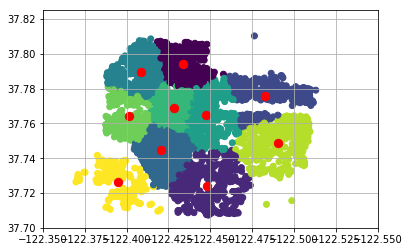

In [396]:
#Como podemos perceber ao comparar os dois gráficos, fica evidente que os imóveis mais caros são concentrados na
#região central da cidade de São Francisco, enquanto que os imóveis mais baratos são concentrados em regiões
#mais periféricas da cidade.

#Portanto, podemos concluir que a localização do imóvel também é um fator crucial na definição do seu preço.

#Apesar da análise exploratória acima ser bastante coerente, precisamos então utilizar algum tipo de resolução 
#que seja confiável, ou seja, usar algum tipo de algoritmo preditivo.

#Para iniciar essa análise então, utilizamos o K-means para clusterização e divisão das localidades em alguns clusters
#Podemos por exemplo melhorar o algoritmo para o X-means, para ser mais acertivo, já que não se sabe
#previamente o número de clusters

kmeans = KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, max_iter = 300)

dataset = []

for latitude, longitude, price in zip(places.latitude, places.longitude, places.price):
    dataset.append([latitude, longitude])

dataset = np.array(dataset)

pred_y = kmeans.fit_predict(dataset)
plt.scatter(dataset[:,1], dataset[:,0], c = pred_y) #posicionamento dos eixos x e y
plt.xlim(-122.35, -122.55) #range do eixo x
plt.ylim(37.7, 37.825) #range do eixo y
plt.grid()
plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0], s = 70, c = 'red') #posição de cada centroide no gráfico
plt.show()
places['cluster'] = pred_y

In [397]:
#além disso, uma estratégia de modelagem de agrupamento de preços foi utilizada, para que a acertividade do algoritmo
#preditivo seja pelo menos interessante. Ou seja, é melhor acertarmos o intervalo com uma acertividade maior do que
#acertar o valor cravado com uma acertividade baixíssima.

def getPrice(price):
    if(price <= 200):
        return 0
    elif(price <= 500):
        return 1
    elif(price <= 700):
        return 2
    elif(price <= 900):
        return 3
    elif(price <= 2000):
        return 4
    elif(price <= 4000):
        return 5
    elif(price <= 6000):
        return 6
    elif(price > 6000):
        return 7
    
places['priceGroup'] = places.apply(lambda row: getPrice(row.price), axis=1)

In [398]:
#além disso, é importante fazermos uma análise de correlação, entre os atributos para saber quais puxam a acertividade
#do priceGroup para cima

dataset = places[[
    'latitude',
    'longitude',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'cluster',
    'review_scores_rating',
    'priceGroup'
]].copy()

places.corr()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,...,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na,cluster,priceGroup
host_total_listings_count,1.00,0.17,0.18,-0.03,-0.01,-0.04,-0.07,0.17,-0.16,0.03,...,-0.01,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.01,-0.01
latitude,0.17,1.00,0.19,-0.04,0.04,-0.10,-0.05,0.15,-0.12,-0.01,...,0.01,0.17,0.17,0.17,0.17,0.17,0.17,0.17,-0.18,0.14
longitude,0.18,0.19,1.00,-0.08,-0.01,-0.11,-0.09,0.11,-0.12,0.01,...,0.02,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.09,0.04
accommodates,-0.03,-0.04,-0.08,1.00,0.35,0.76,0.83,-0.04,-0.08,0.06,...,-0.02,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.02,0.54
bathrooms,-0.01,0.04,-0.01,0.35,1.00,0.41,0.38,0.01,-0.07,-0.02,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,-0.01,0.28
bedrooms,-0.04,-0.10,-0.11,0.76,0.41,1.00,0.74,-0.02,-0.10,0.09,...,-0.01,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.02,0.52
beds,-0.07,-0.05,-0.09,0.83,0.38,0.74,1.00,-0.01,-0.08,0.03,...,-0.02,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.03,0.46
minimum_nights,0.17,0.15,0.11,-0.04,0.01,-0.02,-0.01,1.00,-0.23,-0.08,...,0.01,0.27,0.27,0.27,0.27,0.27,0.27,0.27,-0.01,-0.07
number_of_reviews,-0.16,-0.12,-0.12,-0.08,-0.07,-0.10,-0.08,-0.23,1.00,-0.01,...,-0.02,-0.30,-0.30,-0.30,-0.30,-0.30,-0.30,-0.30,0.02,-0.15
review_scores_rating,0.03,-0.01,0.01,0.06,-0.02,0.09,0.03,-0.08,-0.01,1.00,...,0.01,0.16,0.15,0.15,0.15,0.16,0.15,0.15,0.02,0.12


In [434]:
#Agora finalmente, é hora de prever :)

#A escolha então utilizada foi o algoritmo de florestas aleatórias (Random Forests). A escolha
#dele foi dada a sua versatilidade (pode ser usado tanto como classificação quanto com regressão) e obtem  resultados
#satisfatórios com uma implementação relativamente simples. 

#Para o caso proposto, foi utilizado a resolução por classificadores. A escolha do algoritmo se deu visto que para o 
#teste solicitado, o desempenho não era o fator crucial.

#Os dados complementares dos imóveis compõem o eixo X
X = dataset.iloc[:, 0:8].values
#Enquanto que o preço do imóvel o eixo Y
y = dataset.iloc[:, 8].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #30% do dataset para test e 70% treinamento

classifier = RandomForestClassifier(n_estimators=40, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Acurácia de previsão:",metrics.accuracy_score(y_test, y_pred))
print("Matriz de confusão:",metrics.confusion_matrix(y_test, y_pred))

Acurácia de previsão: 0.8050373134328358
Matriz de confusão: [[1385   96    1    0    1    1    0]
 [ 205  326    8    1    3    0    0]
 [   5   44    4    0    3    0    0]
 [   3   15    2    0    2    0    0]
 [   4   14    2    2   11    0    0]
 [   2    0    0    0    1    0    0]
 [   0    3    0    0    0    0    0]]


In [412]:
#Como podemos observar, obtivemos uma acertividade de cerca de 80%, tornando a predição do preço bastante acertiva
predict = classifier.predict([[37.7693,-122.434, 6, 6, 9, 7, 15, 80]])
predict[0]

1